# What we tweet about when we tweet about mental health

This notebook follows the methodology described in our report in order to answer our research questions.

We provide the following overview for easier navigation:

### Overview:

<ol start="0">
  <li><b>Data Collection &amp; Preliminary Analysis:</b> description of our dataset retrieval and quick analysis of our datasets to familiarize ourselves with them</li>
  <li><b><i>Spinn3r</i> Data Treatment:</b> 
      application of our cleaning and NLP pipeline to the $1^{st}$ dataset</li>
  <li><b><i>Spinn3r</i> Dataset Description:</b> 
      a first (less naive) analysis of the dataset</li>
  <li><b>Dictionary Construction</b> (using the <b><i>Spinn3r</i></b> dataset)<b>:</b> 
      creation (and refining) of the dictionary we are going to use on both datasets</li>
  <li><b><i>Spinn3r</i> Dataset Analysis:</b> 
      first answer to our research questions using the <i>"smaller" <b>Spinn3r</b></i> set</li>
  <li><b><i>twitter-swisscom</i> Data Processing Pipeline:</b> 
      after using the <b><i>Spinn3r</i></b> set as a proof of concept, we apply the cleaning, NLP and keyword-based selection methods to our $2^{nd}$ dataset</li>
  <li><b>Conclusion</b></li>
</ol>

We quickly import the libraries we use in this Notebook (and define our constant values):

In [129]:
import numpy as np
import pandas as pd
import pickle as pkl
import pyspark as ps
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Part 1
import json
from pandas.io.json import json_normalize

#Part 2
import re
import unicodedata
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

#Part 3
import pyLDAvis.gensim
from gensim import corpora, models
import networkx as nx

#Maps display
import folium
import shapely
import pysal as ps
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
from folium.plugins import MarkerCluster
%matplotlib inline

In [2]:
#Charts colors
colors = plt.cm.RdYlBu(np.linspace(.2, .7, 4))
colorsBar = plt.cm.PuBu(np.linspace(.2, .7, 10))

In [3]:
#EXAMPLE DATA
EXAMPLE_PATH = 'data/example_data/'
SP_EX_TWEETS = EXAMPLE_PATH + 'spinn3r_example.json'
TS_EX_TWEETS = EXAMPLE_PATH + 'twitterswisscom_example.tsv'

In [4]:
#SPINN3R DATASETS
SP_PATH = 'data/spinn3r_tweets/'
SP_PROC_TWEETS = SP_PATH + 'processed_tweets.pkl'

In [5]:
#SPINN3R KEYWORDED TWEETS SUBSETS
KW_SP_PATH = SP_PATH + 'keyword_tweets/'
SP_EN_KW = KW_SP_PATH + 'english_keyworded_tweets.pkl'
SP_FR_KW = KW_SP_PATH + 'french_keyworded_tweets.pkl'
SP_DE_KW = KW_SP_PATH + 'german_keyworded_tweets.pkl'
SP_SMALL_EN_KW = KW_SP_PATH + 'small_english_keyworded_tweets.pkl'
SP_SMALL_FR_KW = KW_SP_PATH + 'small_french_keyworded_tweets.pkl'
SP_SMALL_DE_KW = KW_SP_PATH + 'small_german_keyworded_tweets.pkl'

In [6]:
#SPINN3R LABELED TWEETS SUBSETS
LBL_SP_PATH = SP_PATH + 'labeled_tweets/'
SP_EN_LBL = LBL_SP_PATH + 'english_labeled.csv'
SP_NEW_EN_LBL = LBL_SP_PATH + 'new_english_labeled.csv'

In [7]:
#DICTIONARIES
DICT_1 = "data/dictionaries/dict_1.csv"
DICT_2 = "data/dictionaries/dict_2.0.csv"

In [8]:
#TWITTER-SWISSCOM DATASETS
SP_PATH = 'data/twitter-swisscom/'
TWITTERSWISSCOM_PROCESSED_TWEETS = 'data/twitter-swisscom/dataset2_english.csv'

## 0. Data Collection & Preliminary Analysis

### 0.1. Data collection

We were provided two separate datasets containing Swiss tweets formated differently and containing different fields.

Our first dataset (_**Spinn3r**_) did not have any example subset. As a stand-in, we extracted the first JSON file to perform our preliminary analysis. To do this, we used the following commands after connecting to the cluster:

```bash
cluster$ hadoop fs -getmerge /datasets/swiss-tweet/harvest3r_twitter_data_01-01_0.json /buffer/example.json
local$ scp -r gaspar@iccluster060.iccluster.epfl.ch:/buffer/example.json <local-path>
```

An example dataset as well as the complet dataset of (_**twitter-swisscom**_) was retrieved from a provided _'.zip'_ file. 

### 0.2. Preliminary analysis

The goal of this preliminary analysis is to familiarize ourselves with our datasets in order to know if we need to adapt our research questions or enrich the dataset with external information. We will see (below) that the main difference between the two datasets is that the $1^{st}$ dataset (_**Spinn3r**_) only covers a span of 10 months while the data of the $2^{nd}$ dataset (_**twitter-swisscom**_) was collected over multiple years and contains more precise location information. Another difference between the datasets was the fact that the $1^{st}$ contained a column expliciting the _language_, _gender of the user_, and the _predominant sentiment_ of the tweet.

After our analysis, we intended to use **both datasets**. For this reason, we use the $1^{st}$ (smaller) dataset to write our functions and methods. On top of having results, we intended to use this as a proof of concept of our analysis pipeline to be applied to the bigger dataset.

However, due to issues with the larger dataset reducing the amount of defacto available data in the large dataset to the same as in the smal dataset, we use the second dataset for purpose of comparison of keyword co-ocurence.

#### 0.2.1. Dataset 1: _Spinn3r_

The [Spinn3r website](http://docs.spinn3r.com/?Example#content-schema) offers an elaborate description of each available field. Given the amount of data present in the cluster, we only look at a single file (corresponding to a day) to perform our preliminary analysis. This is a nested _JSON_ file. As the *read_json* function does not work well with nested _JSON_ data, we use a _JSON_ normalizer (provided in the _**Pandas.io**_ libary).

In [9]:
with open(SP_EX_TWEETS) as data_file:    
    data = json.load(data_file)

ex_sp_df = json_normalize(data)

#rename columns for convenience
ex_sp_df.columns = [column.replace('_source.','') for column in ex_sp_df.columns]
ex_sp_df.columns

Index(['_id', '_index', '_score', 'author_avatar_img', 'author_gender',
       'author_link', 'author_name', 'bucket', 'canonical', 'date_found',
       'domain', 'hashcode', 'index_method', 'lang', 'links', 'main',
       'main_checksum', 'main_format', 'main_length', 'mentions', 'permalink',
       'published', 'resource', 'sentiment', 'sequence', 'sequence_range',
       'site', 'source_content_checksum', 'source_content_length',
       'source_created', 'source_date_found', 'source_description',
       'source_favicon_height', 'source_favicon_width', 'source_favorites',
       'source_followers', 'source_following', 'source_handle',
       'source_hashcode', 'source_http_status', 'source_image_height',
       'source_image_src', 'source_image_width', 'source_last_posted',
       'source_last_published', 'source_last_updated', 'source_likes',
       'source_link', 'source_location', 'source_parsed_posts',
       'source_parsed_posts_max', 'source_profiles', 'source_publisher_type',


Out of all these fields, we see that the most useful columns for our analysis are:
- **main**: contains the content of the tweet (the center of our analysis).
- **published**: gives the time on which the content was posted.
- **source_location**: location of the tweet.
- **lang**: language of the tweet.
- **author_gender**: gender of the author -MALE, FEMALE, UNKNOWN-.
- **sentiment**: sentiment score of the tweet -POSITIVE, NEGATIVE, NEUTRAL-.

_Note :_ On the cluster we find additional fields, out of which we decide to use **'author_user_id'**, as means to uniquely identify an user and **'geo_point'**, containing latitude and longitude, as a way to identify user location.

In [10]:
#defining the columns to keep
columns = ['main', 'published', 'source_spam_probability', 'source_location', 'tags', 'lang', 'sentiment',
                   'author_gender', 'source_followers', 'source_following']
ex_sp_df = ex_sp_df[columns]

**Looking at categorical data :**

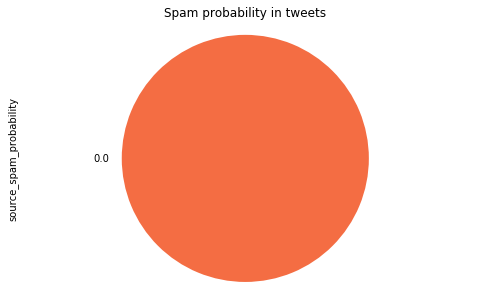

In [11]:
plt.figure(figsize=[8, 5])
ex_sp_df['source_spam_probability'].value_counts().plot(kind='pie', colors=colors)
plt.title('Spam probability in tweets')
plt.axis('equal')
plt.show()

The spam probability of the tweet set seemed very promising to clean our data, but we see that not a single tweet was labeled as spam which makes us question the accuracy of the labeling.

We now look at the values contained in the **source_location** column (which seem to be language dependent):

In [12]:
location_occurences = ex_sp_df[ex_sp_df.lang.isin(['de', 'fr', 'en'])]['source_location'].value_counts()
print('Most frequent:\n' , location_occurences.head(), '\n')
print('Least frequent:\n' , location_occurences.tail())

Most frequent:
 Switzerland    6613
Schweiz        1977
Suisse         1762
Genève         1094
Zürich          961
Name: source_location, dtype: int64 

Least frequent:
 Affoltern am Albis    1
Renens                1
Laufen                1
Poschiavo             1
Suica                 1
Name: source_location, dtype: int64


We notice that:
- A lot of locations only differ in language (e.g. Switzerland, Schweiz and Suisse)
- The locations' names are not always written in languages we are interested in (e.g. สวิตเซอร์แลนด์, a location name in our list)
- A vast majority of the dataset is just located in 'Switzerland'
- Some of the tweets are not located in Switzerland

To deal with these different locations (and display them on a map) we use the **geo_point** field instead.

_Note :_ we choose to not deal with the last point mentioned under the assumption that we were provided with a dataset only containing tweets written in Switzerland.

In [13]:
ex_sp_df.count()

main                       21795
published                  21795
source_spam_probability    21795
source_location            21795
tags                        3865
lang                       21795
sentiment                  20902
author_gender              21795
source_followers           21795
source_following           21795
dtype: int64

When looking at the number of values of the dataset, we see that most tags associated to tweets are missing. This may indicate that tags won't be useful for our analysis, but this does not influence our research at this stage.

We also note that for some tweets, the sentiment is missing. As noted on Spinn3er, this may be due to the fact that some tweets do not contain enough linguistic information to identify the sentiment (we will filter out such tweets). However, this field is not central to our analysis, it is merely used to help us evaluate the treatment applyied to our dataset.

**Identifying potential issues :**

While this set of tweets is not representative, we can still use it to find potential issues we might have with the tweets' content. We will later use this analysis to decide which values to filter out of the dataset.

We start be inspecting a random sample:

In [14]:
pd.set_option('display.max_colwidth', 140)
ex_sp_df.sample(n=10)['main']

15264         We're all looking at the gutter But some of us are livin' with the stars Live fast, leave a pretty body I'll lay it next to you - XYLØ
11647                    2016 wird ein Jahr! Nicht MEIN Jahr, denn ich möchte nicht besitzergreifend wirken, weil politisch korrekt. #noussommes2016
19093             @fitlifefromme please come back and follow me! I really need your support for #flitting now that its time for #resolutions #NY2016
4822                                                                      ♫ Slylab - It's You (Part Two) ♫ Listen: http://bit.ly/l47zPc  #nowplaying
15575    I just decided I definitively skip Touch The Mountains this year. Feels weird but with this line up rather a waste of my energy #justsaying
1282             So startet das #FCSG-Team in das neue Jahr - die Termine im Überblick: http://bit.ly/1PxqdyV  #Happy2016 pic.twitter.com/95KDdEptPb
12837                      Aktuelle Suchabfrage "affolter" auf @Help_ch #affolter #Suchportal #Schweiz #Su

We immediatly see that tweets containing links are not relevant to our research question (they are mostly news or adds).

In [15]:
ex_sp_df.main[ex_sp_df.main.map(lambda x: 'http://' in x)].head(10)

6     Alpinultras. Sello, circuito y estudio médico para potenciar las travesías de ultrafondo de al… http://wp.me/p9GIl-b3O  vía @CarrerasMon...
7                                                                                 5 people unfollowed me today tracked by http://unfollowspy.com 
9                                                                         Wir wünschen euch von Herzen ein gesundes 2016! http://fb.me/7SfcGRpCP 
17                                                                                         Aktuellste Stellenangebote http://tinyurl.com/bugpgs8 
23      Naa geierst Du wieder und willst wichsen..Na gut aber Du musst 2 mal spritzen.Du musst… http://dlvr.it/D8jjgL  pic.twitter.com/LBV2QcdDIF
25                                                                                       AZEALIA BANKS - 212 FT. LAZY JAY http://fb.me/3GqunbPRp 
26         Alles Gute fürs Neue Jahr! Sehen Sie eine Videobotschaft des CEO #Bringhen Group: https://vimeo.com/148510641  ht

Looking at the sample, we generalize this rule and make the assumption that URLs are sign that a tweet is a spam.

Using a very simplified matching research, we see that some words are problematic.

In [16]:
pd.set_option('display.max_colwidth', 100)
ex_sp_df[ex_sp_df['main'].map(lambda x: 'suicide' in x) ]['main']

1731     Suicide bombing kills 1 at Kabul restaurant - http://news.bridgeward.com/suicide-bombing-kills-1...
3624                                              IS suicide attack planned in Munich http://bit.ly/1Owgpls 
5228     Afghanistan: attentat suicide dans un restaurant français de Kaboul - Europe1 http://dlvr.it/D8q...
6896     Ian Murdock's last night alive #debian http://sanfrancisco.cbslocal.com/2015/12/31/prominent-pro...
9479     Ipad Music Making Daily is out! http://paper.li/suicidesurfer77/1315555100?edition_id=bb78ee60-b...
10145     L'Etat islamique soupçonné d'avoir planifié un attentat suicide en Allemagne http://rss.ch/662786 
10446                           Afghanistan: attentat suicide dans le centre de Kaboul http://rss.ch/662843 
11096    Kaboul : les talibans revendiquent l'attentat suicide de ce 1er janvier contre un restaurant fra...
11377     L'Etat islamique soupçonné d'avoir planifié un attentat suicide en Allemagne http://rss.ch/662783 
14771              

We notice that the occurences of the word _**'suicide'**_ in our set are often linked to news. This also comforts us in our choice to remove tweets with URLs in order to get better results.

In [17]:
ex_sp_df[ex_sp_df['main'].map(lambda x: 'therapie' in x) ]['main']

11567    #Arbeit #Jobs #CH Chefarzt Psychiatrie/Psychotherapie 100 (w/m): Herisau, Appenzell Ausserrhoden...
12508    Aktuelle Firmensuche "Physiotherapie Praxis Bücheli" Ostermundigen (BE) #Gesundheitsberatung #Su...
13610    Natürlich Gesund: Mistel und Myrrhe in der Phytotherapie http://pure-natur.blogspot.ch/2014/06/t...
13720    Aktuelle Suchabfrage "Kunsttherapie" auf @Help_ch #Kunsttherapie #Suchportal #Schweiz #Suche htt...
Name: main, dtype: object

Looking at the word _**'therapie'**_ (_therapy_ in German), we can confirm once again the issue with URLs.

In [18]:
ex_sp_df[ex_sp_df['main'].map(lambda x: 'RT ' in x) ]['main'].head()

124     RT @TimeOutSwiss : Discover some of the best ski resorts in #Switzerland #Swissalps #SwissSki #s...
3472    RT @SkafarPierre: General differences in use of social media for health care #hcsm #digitial #so...
3697                           RT @Boehringer: We wish you a happy new year! #Hcsm #hcsmeu #socmed #newyear
3751    RT @Paul_Sonnier: Tech That Will Change Your Life in 2016 http://stfi.re/xzzdya  #IoT #Whealth #...
3786    touche.... https://twitter.com/JamesRobertWebb/status/682951862929080322 … And #SometimesWhenIFe...
Name: main, dtype: object

Finally, we look at the retweets to see if they can be useful. Using these results (and the findings other researchers such as the ones presented in [8]), we see that they are not useful.

## 1. _Spinn3r_ Data Treatment

Now that we have familiarized with our data, we have to clean the datset. To do this, we first apply our functions locally to a small subset to make sure they work as expected. After this, we use Spark to scale up our methods and apply them to all dataset on the cluster.

### 1.1. Tweet filtering

- First, we would like to get rid of any tweets with a spam probability greater than $0.5$ (tweets more likely to be spam than not). 
- As we are only focused on the Swiss population, we only keep tweets written in the country's official languages (except for Italian as no one in our group speaks the language, meaning we won't be able to extract useful information) and in English (as most tweets in the dataset, and more generally on Twitter, are written in English)

In [19]:
#removing spam
spam_mask = (ex_sp_df['source_spam_probability'] >= 0.5)
ex_sp_df.drop(ex_sp_df[spam_mask].index, inplace=True)
ex_sp_df.reset_index(drop=True, inplace=True)

In [20]:
#filtering by language
lang_mask = ~ex_sp_df.lang.isin(['de', 'en', 'fr'])
ex_sp_df.drop(ex_sp_df[lang_mask].index, inplace=True)
ex_sp_df.reset_index(drop=True, inplace=True)

### 1.2. Column formatting

To start, we format the column containing the dates to make the temporal analysis easier.

In [21]:
#convert dates to datetime format
ex_sp_df['published'] = pd.to_datetime(ex_sp_df['published'])
ex_sp_df['published'].head()

0   2016-01-01 00:30:04
1   2016-01-01 12:12:33
2   2016-01-01 19:52:15
3   2016-01-01 11:58:03
4   2016-01-01 06:17:28
Name: published, dtype: datetime64[ns]

As the geo_point data is not standardised, we need to treat both types of geolocation encodings seperately.

As the example dataset does not contain the 'geo_point' field, we just present the function we will apply to do this here.

In [22]:
def process_location_data(df):
    """preprocesses geo data in format as found on cluster
    df: dataframe, locations should be in 'geo_point' column
    """
    #get lines containing geopoint
    non_null = df[~df.geo_point.isnull()]
    
    #location separated by comma format: [longitude, latitude ]
    comma = non_null[non_null.geo_point.str.contains(',')].geo_point.str.split(pat=',', expand=True).applymap(float)
    
    #locations just next to each other [longitude latitude]
    no_comma = non_null[~non_null.geo_point.str.contains(',')].geo_point.str.split(expand=True).applymap(float)
    return pd.concat([comma, no_comma])

### 1.3. Text treatment

Following this mild cleaning, we need to work on the main subject of our analysis: the content of the tweets.

We put all caracters in lowercase (which will allow us to compare the tweets more easily without any case-sensitive-related issues).

In [23]:
ex_sp_df['main'] = ex_sp_df['main'].str.lower()
ex_sp_df['main'].head()

0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                               nice bmw ...he kills ant s!!! pic.twitter.com/5zt5v1mljk
2    @madmenna ich hab nichts dagegen, wenn mir andere beim saufen zuschauen, solange sie pro minute ...
3     happy new jear!!!! i am back from 2 weeks cuba! let s go into the 2016! pic.twitter.com/bu0lbpfql3
4    @megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gra...
Name: main, dtype: object

As we have seen in _Part 1_, URLs are highly linked to spam (except for URLs linking pictures to the tweet). Yet, we also remove all _pic.twitter.com_ URLS as we will not use them either and delete all mentions of the format _"@user"_.

In [24]:
url_mask = ex_sp_df['main'].str.contains("www") | ex_sp_df['main'].str.contains("http")
ex_sp_df['main'] = ex_sp_df['main'].str.replace("pic.twitter\S+", '')
ex_sp_df.drop(ex_sp_df[url_mask].index, inplace=True)
ex_sp_df.reset_index(drop=True, inplace=True)
ex_sp_df['main'].head()

<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<ipython-input-24-7c81e555ead3>:2: DeprecationWarning: invalid escape sequence \S
  ex_sp_df['main'] = ex_sp_df['main'].str.replace("pic.twitter\S+", '')


0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                                                         nice bmw ...he kills ant s!!! 
2    @madmenna ich hab nichts dagegen, wenn mir andere beim saufen zuschauen, solange sie pro minute ...
3                               happy new jear!!!! i am back from 2 weeks cuba! let s go into the 2016! 
4    @megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gra...
Name: main, dtype: object

To finish the text treatment, we delete all non-alphanumeric characters.

In [25]:
alphanum_filter = lambda data: re.sub(r'[^\w\s]', '', data)

In [26]:
ex_sp_df['main'] = ex_sp_df['main'].map(alphanum_filter)
ex_sp_df['main'] = ex_sp_df['main'].str.replace('_', '') #not removed by previous regex
ex_sp_df.main.head()

0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                                                               nice bmw he kills ant s 
2    madmenna ich hab nichts dagegen wenn mir andere beim saufen zuschauen solange sie pro minute 5 z...
3                                     happy new jear i am back from 2 weeks cuba let s go into the 2016 
4    megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gran...
Name: main, dtype: object

### 1.4. Spark version

After performing all these filtering and cleaning steps, the size of the set is **significantly reduced** (the new file only weights **2.4MB** instead of the **55MB** of the original file, allowing us to reduce the set by **30 times**). This is particularly helpful as the whole dataset represents around **30GB**.

_Note:_ the code was written as _**Raw NBConvert**_ as it is not meant to be run on the notebook but on the cluster. The code is only here as information for the reader, it's executable can be found in the run.py script.

We start by importing the necessary elements and defining Spark environment variables.

We then import our data.

We filter tweets using the same method.

Text treatment is a little longer as it is more thorough in Spark.

Finally, we store the data in the _JSON_ we will be using.

### 1.5. Natural Language Processing

Using  Natural Language Processing _(NLP)_ is necessary given that we work with tweets.
We only perform a simple processing pipeline (tokenization and stemming) using the goto NLP python library _**nltk**_. This is useful because we work with tweets from different languages.
We do not use stop word removal at this stage, as we will see that personal pronouns, which would be removed by stop word removal, play an important part in the detection of tweets using out dictonary.



_Note:_ once again, the code was written as _**Raw NBConvert**_ as it takes a long time to run on the dataset (**5+** minutes). The code is only here as information for the reader, it's executable can be found in the *processing_pipeline.py* script.

#### 1.5.1. Helper functions
(cf. _Next part_ below for information)

#### 1.5.2. Tweet formatting

NLP is mainly based on treating the data to obtain an adequate format to work with. It usually follows the 3 steps explicited below:
- **Tokenizing:** separating words, we use a special tweettokenizer to work on the tweets
- **Stemming:** keeping only the radical of a word (allows better comparison)

## 2. Dataset Description for Spinn3r

To be able to provide sound answers to our research questions, we need to analyze our entire dataset to compare it to our final results.

_Note :_ we used the *processing_pipeline.py* for speed and convenience. The results were saved to the *processed_tweets* pkl file which can be found in the _'data/spinn3_tweets'_ folder.

In [27]:
sp_df = pkl.load(open(SP_PROC_TWEETS, "rb" ))

### 2.1. General statistics:

In [28]:
sp_df.count()

author_gender              3936059
author_user_id             3022512
geo_point                  1209109
lang                       3936084
main                       3936084
published                  3936084
sentiment                  3936084
source_followers           3936084
source_following           3936084
source_location            3817038
source_spam_probability    3936084
tags                        638220
cleaned                    3936084
tokenized                  3936084
dtype: int64

We have a total of **3936084** tweets but we note that less than half of them have *geo\_point* values attached to them.

### 2.2. Distribution of categorical data

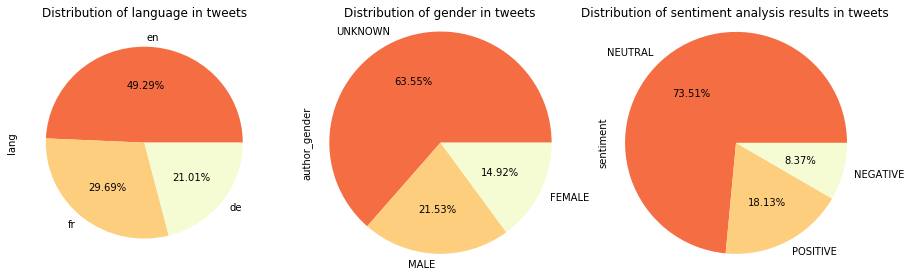

In [29]:
#creating pie charts to show distribution
plt.figure(figsize=(15, 15))

plt.subplot(3,3,1)
sp_df['lang'].value_counts().plot(kind='pie', colors=colors, autopct='%.2f%%')
plt.title('Distribution of language in tweets')

plt.subplot(3,3,2)
sp_df['author_gender'].value_counts().plot(kind='pie', colors=colors, autopct='%.2f%%')
plt.axis('equal')
plt.title('Distribution of gender in tweets')

plt.subplot(3,3,3)
sp_df['sentiment'].value_counts().plot(kind='pie', colors=colors,autopct='%.2f%%')
plt.axis('equal')
plt.title('Distribution of sentiment analysis results in tweets')

1. Almost half of all tweets are in English, French being the next most popular language. This is very interesting because it is quite unexpected given we are looking at tweets which were posted in Switzerland where German is the the most widely used official language with $66\%$ of the country using German, with French speakers making up $22.7\%$. [source](https://en.wikipedia.org/wiki/Languages_of_Switzerland)

2. Most accounts do not contain information on the user's gender (meaning there is no way we can have an unbiased set). However, the dataset still provides the gender of over a third of profiles (even though male and female users are not equally represented), possibly allowing to get some insights on the differences in mental distress expression between the genders.

3. Around $75\%$ of tweets are labeled as being _**NEUTRAL**_, and only $8\%$ are labeled as negative. Taking these labels at face value, this could already indicate that people on twitter do not discuss negative topics – mental health being such a topic – a lot. 

### 2.3. Distribution of temporal data

In [30]:
#Helper functions
def get_time_distribution(times):
    publishing_time = times.map(lambda x: x.hour).value_counts() / times.count()
    publishing_time.sort_index(inplace=True)
    return publishing_time

def plot_daily(df):
    times = get_time_distribution(df['published'])
    return plt.plot(times)


def get_monthly_distribution(times):
    return times.map(lambda x: x.month).value_counts()
    
    
    
def plot_yearly(df):
    year = get_monthly_distribution(df['published'])
    sns.tsplot(data=year, time=year.index)
    plt.ylabel('number of tweets')
    plt.title('Distribution of tweets over a 10 months period')
    plt.xticks(range(1, 11),['jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'oct'])
    plt.xlabel('month')
    plt.show()
    

/Users/lguillain/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


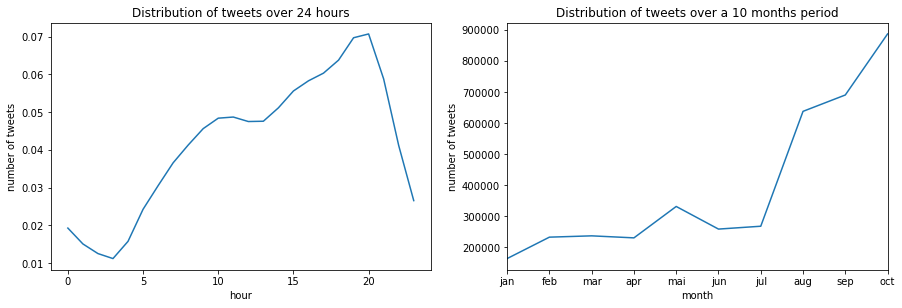

In [31]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
plot_daily(sp_df)
plt.xlabel('hour')
plt.ylabel('number of tweets')
plt.title('Distribution of tweets over 24 hours')


plt.subplot(2,2,2)
plot_yearly(sp_df)


We first look at the daily pattern of data. The highest number of posted tweets is around 8pm (a number decreasing through the night with the lowest pic attained at 3am). Another low point is around lunch time.

When looking at the number of tweets posted throughout the 10 months, we see that the dataset is not balanced (a plausible explanation is the rapidly-increasing number of Twitter users). This could also be linked to the Spinn3r's tweets retrieval method.

### 2.4. Distribution of location data

As previously noted, only $\sim40\%$ of tweets are a geo-localised. However, we can still look at their overall distribution. We use [this tutorial](http://andrewgaidus.com/leaflet_webmaps_python/) (and [the geodata](https://github.com/interactivethings/swiss-maps) provided in the $3^{rd}$ homework) to create our map. We then convert our data into a shapefile using [an online converter](https://mygeodata.cloud/converter/shp-to-geojson).

_Note:_ some points are not located in Switzerland but we do not filter out the attached tweets (we suppose the dataset is correct).

We first match the shapefile format with our location data.

In [32]:
locations = process_location_data(sp_df)
location_geo = gpd.GeoSeries(locations.apply(lambda z: Point(z[1], z[0]), 1), crs={'init': 'epsg:4326'})
location = gpd.GeoDataFrame(sp_df[~sp_df.geo_point.isnull()], geometry=location_geo) #merged data –useful later on–

In [33]:
municipalities = gpd.read_file('data/geodata/ch-municipalities.shp') #load data
municipalities.geometry = municipalities.geometry.to_crs(location_geo.crs) #change format

Using _**gdp**_'s library, we find occurences per municipality and _'beautify'_ the data display.

In [34]:
#join between region and location
counts = gpd.tools.sjoin(location, municipalities).groupby('id').size()

In [35]:
#add counts to the regions
municipalities.set_index('id', inplace=True)
municipalities['counts'] = counts
municipalities.fillna(0, inplace=True) #if we can't find match we have 0 tweets
municipalities.reset_index(inplace=True)

We display using 2 layers to get more granularity (we plot the municipalities with less than 10 tweets on a different layer).

In [36]:
municipalities_0 = municipalities[municipalities.counts < 10]
municipalities_1 = municipalities[municipalities.counts >= 10]

Using this data, we create our map.

In [37]:
SWISS_COORD = [46.85, 8.23]
swiss_map = folium.Map(location = SWISS_COORD, zoom_start = 8, tiles = 'cartodbpositron')

#layer with municipalities containing more than 10 tweets
swiss_map.choropleth(municipalities_1.to_json(), data = municipalities_1,
                     key_on = 'feature.properties.{}'.format('id'),
                    columns = ['id', 'counts'], fill_color = 'PuRd',
                     threshold_scale=[11, 500, 1000, 2000, 5000, 10000],
                     legend_name='Number of tweets', fill_opacity=0.9)
#layer with municipalities containing less than 10 tweets in total
swiss_map.choropleth(municipalities_0.to_json(), data = municipalities_0, 
                     key_on = 'feature.properties.{}'.format('id'),
                     columns = ['id', 'counts'], fill_color = 'PuBu', 
                     threshold_scale=[0, 10], legend_name='Area of little to no data',
                     fill_opacity=0.1, line_opacity=0.3)

As we cannot display folium maps in an _'.ipynb'_ file on GitHub, in addition it being quite large, we save our map to an HTML file so it an be viewed independently.

In [38]:
swiss_map.save('municipalities_map.html')

In [39]:
%%HTML
<iframe width='900' height="500" src="municipalities_map.html"></iframe>

We see that tweets are strongly concentrated in urban centers. This will have to be taken into consideration when looking at the Röstigraben and urban/rural differences.

## 3. Dictionary Construction

### 3.1. Building the dictionary

The first step in building our dictionary was research (we use dictionnaries shown in [2] and [3] as they were used for similar problems). As we work with tweets in multiple languages, we translate them carefuly into French and German. We decided to add multiple appropriate synonyms in the translation for words that have many synonyms (as is the case with German). 

In [40]:
dict_1 = pd.read_csv(DICT_1)
dict_1.head(10)

,english,french,german
0,mental health,santé mentale,psychische gesundheit
1,depression,depression,depression
2,eating disorder,trouble du comportement alimentaire,essstörung
3,suicide,suicide,selbstmord
4,ptsd,stress post-traumatique,ptbs
5,mental illness,maladie mentale,geisteserkrankung
6,addiction,toxicomanie,abhängigkeit
7,bipolar,bipolaire,manisch depressiv
8,NaN,psychiatrie,suizid
9,NaN,NaN,geistige gesundheit


In [41]:
dict_2 = pd.read_csv(DICT_2)
dict_2.head(10)

,english,french,german
0,antidepressants,antidépresseur,anti depressiva
1,anxiety,anxiété,angstgefühl
2,ashamed of myself,honte de moi-même,mich schähmen
3,bipolar,bipolaire,manisch depressiv
4,bipolar disorder,trouble bipolaire,bipolare störung
5,feeling blue,avoir le cafard,deprimiert sein
6,cheerless,sombre,freudlos
7,cymbalta,cymbalta,cymbalta
8,dejection,déprime,bedrücktheit
9,depression,dépression,depression


We apply our cleaning pipeline to the termes in the dictionary so that words in our dictionary can be matched to our processed tweets.

_Note :_ we only show the pipeline application to the $1^{st}$ dictionary as an example. The actual cleaning (and matching of keywords) is done in the *dict_filtering.py* script and saved to a pkl file (stored in the *'data/spinn3r_tweets/keyworded_tweets'* folder).

In [42]:
en_dict = dict_2['english'].dropna()
fr_dict = dict_2['french'].dropna()
de_dict = dict_2['german'].dropna()

In [43]:
tknzr = TweetTokenizer()
en_dict = en_dict.map(lambda x: tknzr.tokenize(x))
fr_dict = fr_dict.map(lambda x: tknzr.tokenize(x))
de_dict = de_dict.map(lambda x: tknzr.tokenize(x))

After cleaning and tokenizing, the dictionnaries look like this:

In [44]:
en_dict.head()

0        [antidepressants]
1                [anxiety]
2    [ashamed, of, myself]
3                [bipolar]
4      [bipolar, disorder]
Name: english, dtype: object

In [45]:
fr_dict.head()

0         [antidépresseur]
1                [anxiété]
2    [honte, de, moi-même]
3              [bipolaire]
4     [trouble, bipolaire]
Name: french, dtype: object

In [46]:
de_dict.head()

0      [anti, depressiva]
1           [angstgefühl]
2        [mich, schähmen]
3    [manisch, depressiv]
4     [bipolare, störung]
Name: german, dtype: object

### 3.2. Processing the dictionary

Once we have our (clean) data, we simply run all the previous NLP methods on our dictionaries.

In [47]:
def dict_remove_stops(dictionary, language):
    lang = language[:2]
    if language == 'german':
        lang = 'de'

    lang_set = stopwords.words(language)
    return dictionary.apply(lambda expression: [word for word in expression if word not in lang_set])

def dict_stem_words(dictionary, language):
    lang = language[:2]
    if language == 'german':
        lang = 'de'

    stemmer = SnowballStemmer(language)

    return dictionary.apply(lambda expression: [stemmer.stem(word) for word in expression])

In [48]:
en_dict = dict_stem_words(en_dict, 'english')
fr_dict =  dict_stem_words(fr_dict, 'french')
de_dict =  dict_stem_words(de_dict, 'german')

After stemming and stop word removal, the dictionaries look like this :

In [49]:
en_dict.head()

0          [antidepress]
1              [anxieti]
2    [asham, of, myself]
3              [bipolar]
4      [bipolar, disord]
Name: english, dtype: object

In [50]:
fr_dict.head()

0       [antidépresseur]
1               [anxiet]
2    [hont, de, moi-mêm]
3             [bipolair]
4     [troubl, bipolair]
Name: french, dtype: object

In [51]:
de_dict.head()

0      [anti, depressiva]
1           [angstgefuhl]
2          [mich, schahm]
3    [manisch, depressiv]
4      [bipolar, storung]
Name: german, dtype: object

### 3.3 Finding keyword matches

We define to following helper functions to find matches:

In [52]:
def compare(s, t):
    """compares to lists, and returns 
    true for all possible permutations of same list
    s, t: lists to compare
    """
    return Counter(s) == Counter(t)

def match_dict(tweet, dict_):
    """returns keywords that match in string
    tweet: tweet to find keywords in
    dict_: list of keywords
    """
    #should we explain this more?
    doc = [sublist for sublist in dict_ if compare(list(filter(lambda x: x in tweet, sublist)), sublist) ]
    return doc #at least one match

We perform the actual algorithm in a script and save the results into a pickle file.

Now that we have our dictionaries, we filter the tweets to keep the ones where keyword occurs at least once in the tweets.

To find matches, we apply a mapping in the following way:

_Note:_ the actual algorithm was performed using *the dict_filtering_small.py* script and the results were saved to pickle files in the *'data/spinn3r_tweets/keyworded_tweets'* folder.

#### 3.3.1. Dictonary 1


We define the following function to look at keyword occurences and coocurrences:

In [53]:
def plot_occurences(keywords):
    keywords.map(lambda x: ' '.join(x[0])).value_counts().plot(kind='bar')
    plt.title('Keyword occurences')
    plt.ylabel('number of tweets')
    plt.show()
    
def get_keyword_stats(df):
    filtered = df[(df.keywords.map(lambda x: x != [] ))]
    print('number of matching tweets: ', filtered.main.count())
    print('percentage of matching tweets: ', filtered.main.count() / df.main.count())
    print('Some lines from the dataframe: ')
    return filtered

In [54]:
def get_coocurrences(filtered):
    return filtered[filtered.keywords.map(lambda x: 3 > len(x) > 1)].keywords.map(lambda x: [' '.join(sub) for sub in x])

def draw_coocurences(cooccurences):
    dictionary = corpora.Dictionary(cooccurences)

    edges = cooccurences.map(lambda x: [dictionary.token2id[sub] for sub in x])

    lists = dictionary.token2id.keys()

    G = nx.Graph()
    G.add_nodes_from(lists)
    #G.add_edges_from(edges, weight=1)

    for edge in cooccurences:
        if(G.has_edge(edge[0], edge[1])):
            weight = G[edge[0]][edge[1]]['weight']
            G.add_edge(edge[0], edge[1], weight = 1+weight)
        else:
            G.add_edge(edge[0], edge[1], weight = 1)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    size = len(lists)/2
    plt.figure(figsize=(size, size))
    nx.draw_circular(G, with_labels=True, width=np.sqrt(weights), node_size=2000, node_color='w')
    plt.show()

**English results :**

In [55]:
df = pkl.load(open(SP_SMALL_EN_KW, "rb" ))
small_english_filtered = get_keyword_stats(df)
small_english_filtered[['main', 'keywords']].head()

number of matching tweets:  3754
percentage of matching tweets:  0.00193477329807
Some lines from the dataframe: 


,main,keywords
2515,"@yhansolo civil war, bfg, jungle book, dory, warcraft, suicide squad, fantastic beasts, passengers",[[suicid]]
4700,@modestlord suicide is an option modest,[[suicid]]
4710,@vedaguru29 @pulkitsamrat and she is addicted to that one hero in the movie hehe:),[[addict]]
5754,can't wait for my computer to die for real so i can have a real reason to commit suicide,[[suicid]]
6784,social media so addictive?,[[addict]]


We see that we get very few results using this dictionary. Less than $0.2\%$ of all tweets match at least one keyword. This is not surprising as these are quite specialized terms.

Even though some tweets indeed show signs of mental health issues, some are completely unrelated to mental health. This discussion will be explicited in the Dictionary Evaluation (Parts _3.4_ and _3.5_).

The fact that despite the few matches we get false positives indicates that the total number of true matching tweets is even smaller.

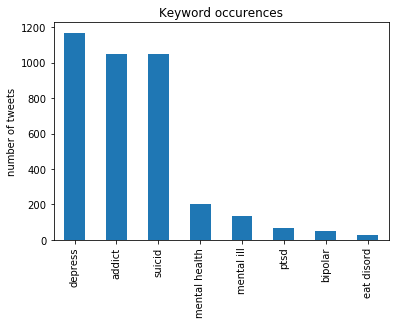

In [56]:
plot_occurences(small_english_filtered.keywords)

The 3 most frequent keywords are _depress_, _addict_ and _suicid_, which are often casually used compared to the 5 other words we see in the chart.

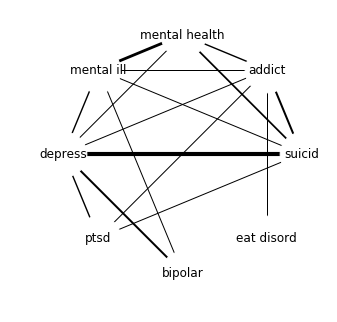

In [57]:
cooccurences = get_coocurrences(small_english_filtered)
draw_coocurences(cooccurences)

**French results :**

In [58]:
df = pkl.load(open(SP_SMALL_FR_KW, "rb" ))

small_french_filtered = get_keyword_stats(df)
small_french_filtered[['main', 'keywords']].head()

number of matching tweets:  1141
percentage of matching tweets:  0.000976298451271
Some lines from the dataframe: 


,main,keywords
5297,"bon je vais arrêter de me plaindre car je sens les gens venir me dire ""suicide-toi."" ou ""ta gueu...",[[suicid]]
8452,@uptobox_com @__tagueule ouais mais cet utilisateur a pas eu la chance de payer que 10€ pour le ...,"[[sant, mental]]"
9127,jv me suicide sa mere,[[suicid]]
9953,mentalement malade,"[[malad, mental]]"
12736,"@waikikifrance euh ça, ça date déjà un peu!!!! lol! et il était à la retraite! c'est justement c...",[[suicid]]


We notice that there are 3 times less matching tweets than in English, which can partially be explained by the fact that the ratio of matching tweets is not the same in both languages. Looking at the percentage of matching tweets we see that only $0.09\%$ of all french tweets contain at least one match.

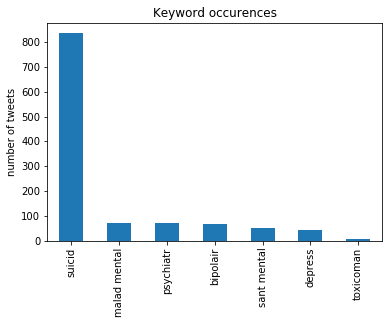

In [59]:
plot_occurences(small_french_filtered.keywords)

When it comes to French, the keyword _'suicid'_ is by far the most frequent, which all other words being used quite infrequently, having less than 100 matching tweets each.

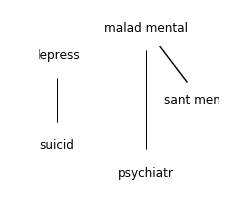

In [60]:
cooccurences = get_coocurrences(small_french_filtered)
draw_coocurences(cooccurences)

**German results :**

In [61]:
df = pkl.load(open(SP_SMALL_DE_KW, "rb" ))
small_german_filtered = get_keyword_stats(df)
small_german_filtered[['main', 'keywords']].head()

number of matching tweets:  604
percentage of matching tweets:  0.000730257947903
Some lines from the dataframe: 


,main,keywords
3993,@mcmandl ich würde es von der qualität der pizza abhängig machen ;-),[[abhang]]
8625,"@netklar ich fühle mich auch nicht immer so arg hinterher wie heute, das ist sehr tagesform abhä...",[[abhang]]
11871,@schaerwords psychiater/kliniken können auch nicht jeden suizid verhindern. kann man dann auch s...,[[suizid]]
22578,depressione wege dere lap. weiss gar nöd was lerne. lol. 50 ordner?,[[depression]]
34780,@juergwyss @hofnaerrin zürcher pass verursacht kein #ptbs im fall! *grrr*,[[ptbs]]


In German, the number of matching tweets is even lower, despite having used synonyms to compensate for the multitude of possible matching words.

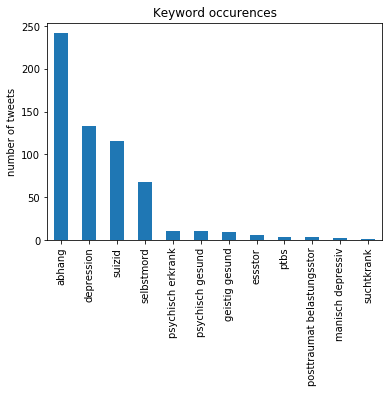

In [62]:
plot_occurences(small_german_filtered.keywords)

Looking at the keyword frequencies, we see that similar to english, addiction, depression and suicide ['abhang', 'depression', 'suizid', 'selbstmord'] are the most frequent keywords, which the other keywords in the dictionary having much fewer matches. 

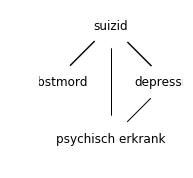

In [63]:
cooccurences = get_coocurrences(small_german_filtered)
draw_coocurences(cooccurences)

#### 3.3.2. Dictionary 2


We now look at the second dictionary retrived from previous research. This dictionary contains a broader range of words, and is a superset of the previous dictionary.

**English results :**

In [64]:
df = pkl.load(open(SP_EN_KW, "rb" ))
english_filtered = get_keyword_stats(df)
english_filtered[['main', 'keywords']].head()

number of matching tweets:  19763
percentage of matching tweets:  0.0101856485588
Some lines from the dataframe: 


,main,keywords
177,@doremineko_ i feel sad that they have to hide and probably won't ever be able to go out and hav...,[[sad]]
299,but hani's dating news makes me feel sad... because it's not normal that idols have to hide thei...,[[sad]]
996,i hate myself for loving chocolate... how to stop craving for sugar?????,"[[hate, myself]]"
1725,everything's empty without you,[[empti]]
2220,wow… i am deeply worried now…,[[worri]]


At first glance we can see that this dictionary gives us many more matches, with about $1\%$ of all english tweets containing at least one keyword. We also see that the matches tend to be more general about feelings and less about specific illnesses.

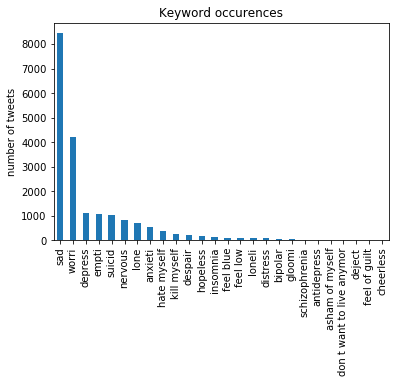

In [65]:
plot_occurences(english_filtered.keywords)

Even though not all tweets express distress (just as before), we can clearly see sadness, loneliness or fear. We also notice that the number of matching tweets has increased greatly (around x10).

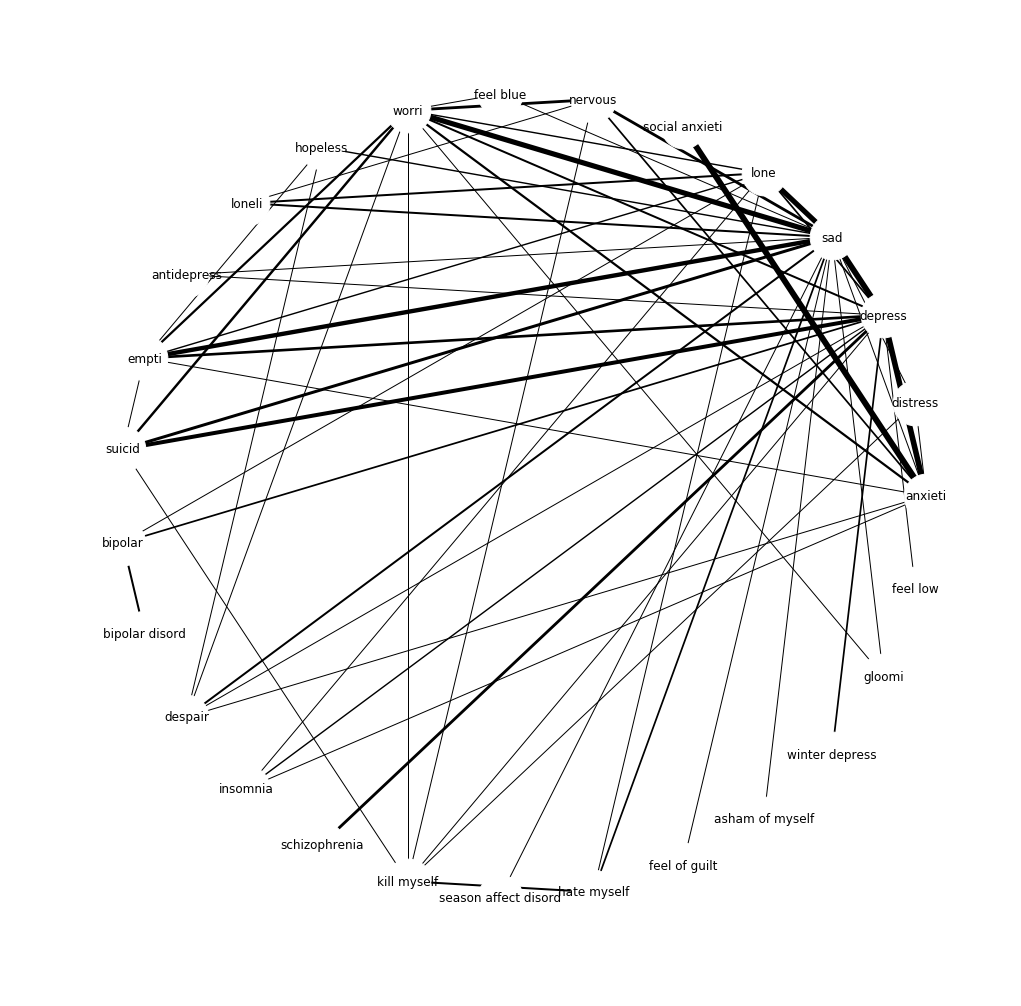

In [66]:
cooccurences = get_coocurrences(english_filtered)
draw_coocurences(cooccurences)

**French results :**

For french we find similar results as for english. We have more matches, and these are less specific to mental illness:

In [67]:
df = pkl.load(open(SP_FR_KW, "rb" ))
french_filtered = get_keyword_stats(df)
french_filtered[['main', 'keywords']].head()

number of matching tweets:  15719
percentage of matching tweets:  0.0134499871652
Some lines from the dataframe: 


,main,keywords
261,@amimisidibe ooh ptn mais tgl sa me blesse toi tu commences l'année avec moi en me disant le mot...,"[[me, tu]]"
662,"@cloudbreaker_ arf moi je déteste le dos, je suis sous musclée donc c'est ce sur quoi je dois me...","[[je, me, détest]]"
1013,confessions intimes sa me tue,"[[me, tu]]"
1073,tu oses prétendre que tu me mens pas alors que tu m'appelle par mon nom complet? baaaaaaarh cala...,"[[me, tu]]"
1546,hier soir j'ai bu seulement un verre de vin. c'est ça le plus triste.,[[trist]]


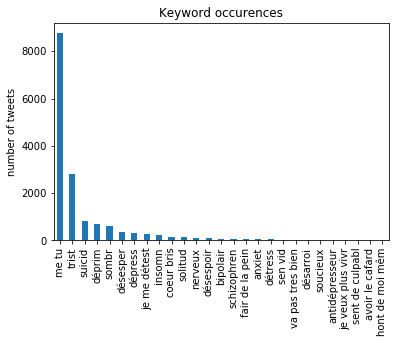

In [68]:
plot_occurences(french_filtered.keywords)

Looking at the words we see that 'kill' or 'die' is by far the most frequent, followed by words like 'sadness' and 'hate'. It thus gives similar results to English. We also find that suicide is still comparetively quite frequent, even with the addition of other words.

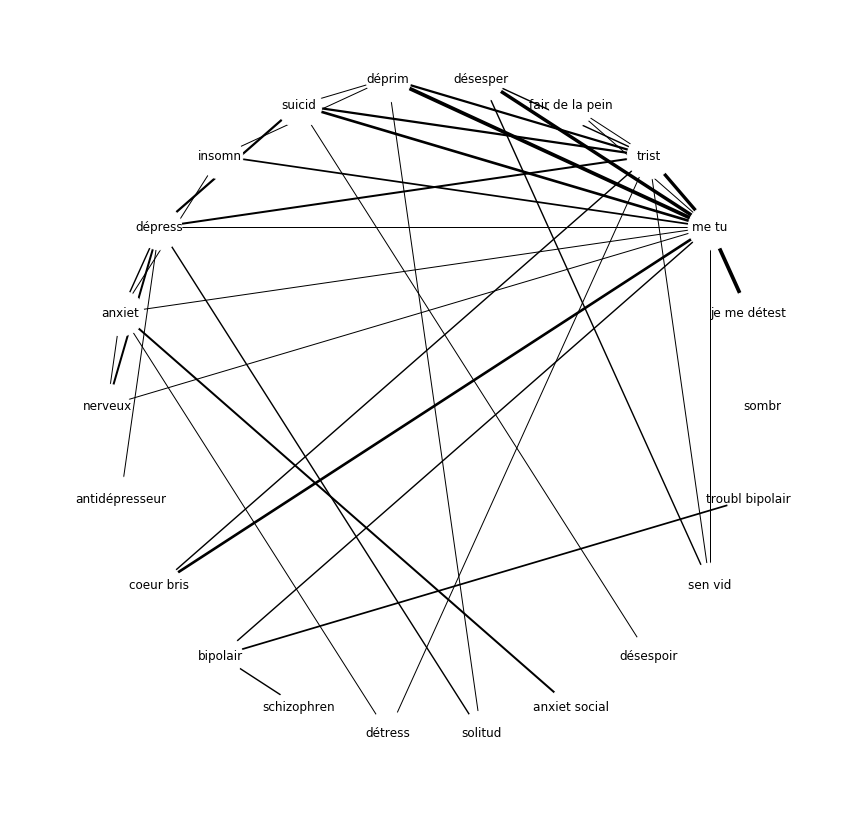

In [69]:
cooccurences = get_coocurrences(french_filtered)
draw_coocurences(cooccurences)

**German results :**

German also shows an increase in matches with the larger dictionary. However, due to the number of matches being small originally, the total number of matches is still quite small.

In [70]:
df = pkl.load(open(SP_DE_KW, "rb" ))
german_filtered = get_keyword_stats(df)
german_filtered[['main', 'keywords']].head()

number of matching tweets:  3627
percentage of matching tweets:  0.00438517479643
Some lines from the dataframe: 


,main,keywords
690,aber es geht ihr wieder besser.. trotzdem. sie wird nie wieder die alte sein & das macht mich tr...,[[traurig]]
698,"@infodesignerin ja wohlwollend meinten die anderen rose, aber nur weil ich so traurig war, dass ...",[[traurig]]
752,"letztes jahr war ich einfach sternhagelvoll, der club war leer & meine freunde knapp angetrunken...",[[leer]]
2119,"@ireneblaser alleinstehend geht ja, solange man zufrieden ist. einsam sein find ich traurig. @co...","[[einsam], [einsam], [traurig]]"
3927,definiere einsamkeit: die strassen auf dem weg zur arbeit am 1. januar.,"[[einsam], [einsam]]"


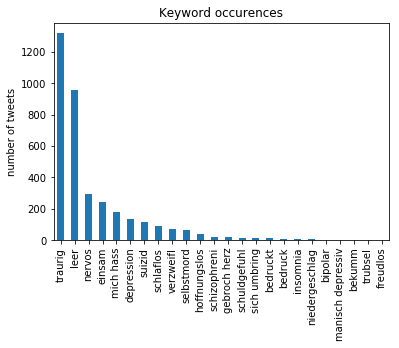

In [71]:
plot_occurences(german_filtered.keywords)

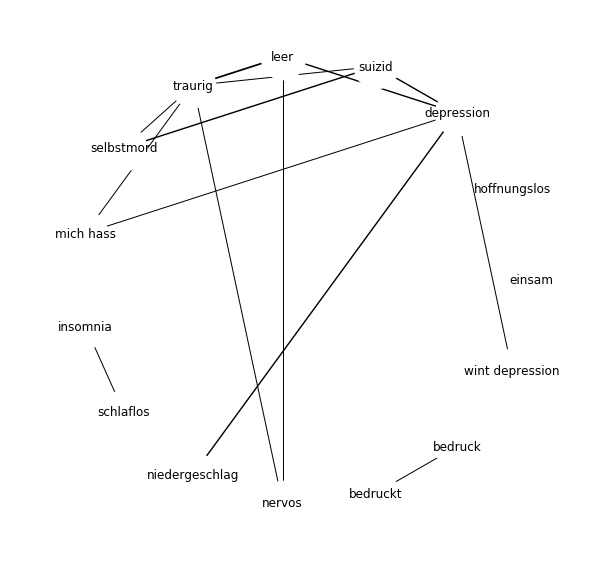

In [72]:
cooccurences = get_coocurrences(german_filtered)
draw_coocurences(cooccurences)

We note that the most frequent words are again 'sad', followed by expressions of loneliness and emptiness.

### 3.4. Dictionary evaluation (using our sample labeling process)

#### 3.4.0. Helper functions

In [73]:
def tweet_search(df, word):
    return df[df['main'].map(lambda x: word in x)]['main']

In [74]:
def md_search(df, word, col):
    md_count = df[df[col].map(lambda x: word in x) & df['mental'] == 1][col].count()
    print("Tweets showing mental distress and containing the word '" + word + "': " , md_count)
    count = df[df[col].map(lambda x: word in x)][col].count()
    print("Total appearance of the word '" + word + "': " , count)
    print("Ratio between these 2 numbers : ", md_count/count)

In [75]:
def blacklisted_search(df, word):
    count = df[df['split'].map(lambda x: word in x)]['split'].count()
    print("Total appearance of '" + word + "': ", count)

After crossing the dataset with our second dictionary to retrieve tweets exhibiting _mental distress_, we labeled a sample to see if the tweets indeed show such signs. 

Note that this task is complex as it is very subjective (choosing tweets displaying mental health issues was done at the discretion of the person labeling them). Our main conclusion from this step was the necessity to "expand" our research to tweets showing signs of mental distress in general and not only mentioning mental illnesses.

In [76]:
first_iter = pd.read_csv(SP_EN_LBL)
first_iter.main.head()

0                                  i am overwhelmed debatenight
1    andrus channeling his inner game 5 self ourmoment bluejays
2                           im so stresseeeeed for my math exam
3                in other news water is wet and the sky is blue
4                               its been a while he was overdue
Name: main, dtype: object

#### 3.4.1. Key _(qualitative)_ takeaways

- Tweets were labeled "losely" using multiple signs of mental distress, mostly sadness. Tweets with the following specificities were labeled as showing mental distress: 
    - nostalgia (either for the past or simply for the end of a nice day)
    - mention of sad activities (people who watched sad movies, listened to sad songs as this was most probably triggered by a previous feeling of sadness)
    - mention of being mad (either over other people like haters or, more often, mad with their families)
 

- Some tweets mentioned the mental distress of other people (either how they helped them or raising awareness over these issues)
- Some tweets showed desperation (a form of mental distress) over the "way the world is", these were not included.

- An unexpected insight (which we decided not to pursue further as it was too tenuous) was the link between summer and mental distress. Indeed, most of tweets mentioning summer showed some sadness due to the absence of friends (from university for example).
- Some tweets only included _"motivational"_ quotes. We can suppose that these reflect bad times. Nonetheless, these were not included as our previous assumption is a little far-fetched. Moreover, this could have messed with our model (they did not include specific words of our dictionary nor specific mentions to mental distress).

- A lot of mental distress tweets are related to unilateral feelings. They are often messages specifically targeted at someone who most certainly doesn't know of their existence (for example work collegues or college classmates).

- Most tweets talking about depression or terrible low self-esteem show _« covert-humour »_, a coping technique used to hide ones self-deprecation. These tweets are very difficult to detect as they use sarcasm (which can not be perceived using current NLP techniques) and seldom use words from our dictionary.

#### 3.4.2. Key _(quantitative)_ takeaways

After the labeling, we found the necessity of both changing our current dictionary (through additions but also removals) and creating a new dictionary (which we decided to call a _negative_ dictionary, but is simply a blacklist of words we did not want to appear anymore).

**Words to include in our dictionary :**

In [77]:
tweet_search(first_iter, 'unfortunately')

417        this is a sad story unfortunately a true one
Name: main, dtype: object

In [78]:
tweet_search(first_iter, 'therapy')

471    i forgot how much i hated therapy talks
Name: main, dtype: object

In [79]:
tweet_search(first_iter, 'overthinking')

424    dont catch the wrong vibe overthinking
561                         0202 overthinking
Name: main, dtype: object

Even though these expressions do not appear very often, they are unique to tweets showing mental distress. Thus, we decide to include them in our new dictionary.

**Words to remove from our dictionary :**

In [80]:
md_search(first_iter, 'hate', 'split')

Tweets showing mental distress and containing the word 'hate':  81
Total appearance of the word 'hate':  193
Ratio between these 2 numbers :  0.419689119171


In [81]:
md_search(first_iter, 'pain', 'split')

Tweets showing mental distress and containing the word 'pain':  17
Total appearance of the word 'pain':  77
Ratio between these 2 numbers :  0.220779220779


In [82]:
md_search(first_iter, 'addict', 'split')

Tweets showing mental distress and containing the word 'addict':  3
Total appearance of the word 'addict':  14
Ratio between these 2 numbers :  0.214285714286


Even though we decided to exclude many words (_hate_, _hurt_, _pain_, _addict_ and _overdose_), we decided to demonstrate our method only on a few. When looking at the number, we see that more than half the tweets containing the (previously) specified words are false positives, which drives us to strike them from our dictionary.

**Words to blacklist :**

In [83]:
blacklisted_search(first_iter, 'overw')
blacklisted_search(first_iter, 'overwatch')

Total appearance of 'overw':  27
Total appearance of 'overwatch':  13


In [84]:
blacklisted_search(first_iter, 'syria')
blacklisted_search(first_iter, 'assad')
blacklisted_search(first_iter, 'asylum')

Total appearance of 'syria':  21
Total appearance of 'assad':  27
Total appearance of 'asylum':  5


In [85]:
blacklisted_search(first_iter, 'trump')
blacklisted_search(first_iter, 'clinton')
blacklisted_search(first_iter, 'america')
blacklisted_search(first_iter, 'usa')

Total appearance of 'trump':  7
Total appearance of 'clinton':  2
Total appearance of 'america':  5
Total appearance of 'usa':  6


As we can see, the words we want to strike represent major recurring themes (mostly having to do with the news) which do not have anything to do with mental distress (none of these tweets were labeled as showing signs of mental distress). Once again, we only showed our idea on a small subset of topics, the list of words we want to blacklist is : _gov_, _government_, _syria_, _assad_, _refugees_, _asylum_, _overwatch_, _vine_, _trump_, _hillary_, _america_, _usa_ and _india_. 

_Note:_ two other expressions are blacklisted, but that is due to our first research algorithm (which did not match perfectly the strings) : _suicidesquad_ (contains _suicide_) and _spain_ (contains _pain_)

#### 3.4.3. French and German labeling

When labeling the other languages, we saw that only $\sim10\%$ of tweets containing at least a keyword from a dictionary actually showed mental distress. Improving the dictionnaries would probably give better results, but as no research of this kind has been done in these languages, we can only improve our results through many iterations (and labeling steps). As this is too time-consuming and uncertain, we decided to drop both languages and concentrate on English. 

### 3.5. Dictionary evaluation (using LDA)

Once again, we only work with tweets which were crossed with our second dictionary. As this is applied on a larger scale than our labeling, it allows us to show subjects which should be avoided (as showed when constructing our _negative_ dictionary).

We confirm the results found in the labeling and add additional blacklisted words.

_Note :_ we use a script we build our LDA models on and save them to the _'data/models'_ folder. We will quickly present these models we created but our focus will be on understanding them (and displaying our results using the _**pyLDAvis**_ library).

#### 3.5.1. Building an English LDA model

To build our LDA model, we need to create a dictionary and define 'texts' (in our case the tweets). This model is then passed to gensim, which then implements the proper LDA model construction. The number of topics was chose was of a size such that a human could interpret them easily. The number of passes and iterations were chosen to be as large as possible, as the corpus we are working on is relatively small.

In [86]:
#remove stopwords for more meaningful results
english_stop_rem = dict_remove_stops(english_filtered.tokenized, 'english')

In [87]:
dictionary = corpora.Dictionary(english_stop_rem)
dictionary.filter_extremes(no_below=2, no_above=.8) #removes too frequent / sparse words
texts = english_stop_rem.tolist()
corpus = [dictionary.doc2bow(text) for text in texts]

In [88]:
#Code used to form the LDA model
ldamodel = models.LdaMulticore(corpus, id2word=dictionary, num_topics=15, workers=3, iterations=100, passes=10)

After loading our LDA model, we evaluate it using the most frequent word distribution of each topic. We can already notice distinct words in Topic 3 (centers around words such as 'syria' and 'muslim').

In [89]:
ldamodel = models.LdaModel.load('models/english.model')
ldamodel.show_topics()

[(0,
  '0.048*"empti" + 0.028*"worri" + 0.018*"lone" + 0.015*"feel" + 0.015*"sad" + 0.012*"like" + 0.008*"suicid" + 0.006*"never" + 0.005*"still" + 0.005*"take"'),
 (1,
  '0.079*"worri" + 0.029*"suicid" + 0.020*"sad" + 0.013*"get" + 0.011*"squad" + 0.010*"dont" + 0.009*"go" + 0.009*"see" + 0.008*"make" + 0.007*"good"'),
 (2,
  '0.029*"nervous" + 0.016*"sad" + 0.015*"hate" + 0.015*"feel" + 0.010*"like" + 0.010*"empti" + 0.009*"day" + 0.007*"suicid" + 0.007*"sunshin" + 0.007*"use"'),
 (3,
  '0.119*"sad" + 0.018*"worri" + 0.016*"veri" + 0.012*"day" + 0.010*"depress" + 0.010*"time" + 0.008*"make" + 0.008*"news" + 0.006*"one" + 0.006*"year"'),
 (4,
  '0.071*"sad" + 0.019*"make" + 0.016*"like" + 0.014*"depress" + 0.013*"feel" + 0.009*"peopl" + 0.009*"lone" + 0.008*"one" + 0.007*"know" + 0.007*"realli"'),
 (5,
  '0.058*"sad" + 0.032*"worri" + 0.023*"love" + 0.015*"im" + 0.014*"know" + 0.014*"go" + 0.011*"realli" + 0.011*"get" + 0.010*"come" + 0.010*"see"')]

In [90]:
#Creating the visualisation
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/lguillain/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


We use the $\lambda$ slider to give names a human could understand to the topics:

- **1 & 2 :** general topics talking about everyday distress, contains specific words such as relationship, teacher, sunday, gloomy
- **3 :** wars & terrorism seem to be the main topic, we see keywords such as muslim, terroist, usa, syria, aleppo, kill, bomb
- **4 & 5:** mentions of suicide squad (a movie that came out in 2016 ), less easy to identify as an overall topic, japan and whaling related tweets seem to be in this topic aswell
- **6 :** mentions of play, music (specificaly gnash and his song i hate u, i love u ft. olivia o'brien), this topic seems to have formed due to the many mentions of this song in tweets.

We see that common specific words in topic 3, 4, 5 and 6 should be excluded from our dictionary search.

### 3.6. Dictionary update (using a second sample labeling)

After everything that we found above, we updated our dictionary to refine our output. The following analysis follows the labeling of a new sample from the dataset evaluated using the new dictionary. We will use all these takeaways to update our dictionary one last time (without analysing it again). 

In [91]:
second_iter = pd.read_csv(SP_NEW_EN_LBL)
second_iter.head()

,Unnamed: 0,main,mental,sentiment,author_gender,keywords
0,1893905,@dyiicious @marrieletsgo the vo of s;g is one of the best vo ever made so it would be sad to wat...,NaN,POSITIVE,UNKNOWN,[['sad']]
1,1710839,i am so sad,1.0,NEGATIVE,FEMALE,[['sad']]
2,323788,@heatherpeace i'm so sad that i can't see you on sunday but my work begins monday at 2:00 perhap...,NaN,NEUTRAL,FEMALE,[['sad']]
3,1692890,"@gengiee don't i love this one she looks so sad, as sad as your life",NaN,NEGATIVE,UNKNOWN,[['sad']]
4,3904507,facebook updates could help understand — and potentially treat — mental health disorders,NaN,NEUTRAL,UNKNOWN,"[['mental', 'health']]"


#### 3.6.1. Key _(qualitative)_ takeaways

Unlike the first pass on the data, this labeling does not include a thorough qualitative analysis. It only allowed us to improve our methodology and find plausible answers to some of the phenomena we observed. 

One of such phenomena is the difference in emotional expression between the genders. This may be due to the (very high) number of tweets by _"fangirls"_, female tweet authors mentioning their love for their favorite music bands (mostly Asian) or one of their favorite actors.

#### 3.6.2. Key _(quantitative)_ takeaways

In this case, we only determine words to add both to our dictionary and to our _negative_ dictionary (no word in our dictionary was deemed superfluous or inducing too many false positives).

**Words to add to our dictionary :**

In [92]:
tweet_search(second_iter, 'breakdown')

7      @urunderarrest poor public education, the breakdown of the family and horrible parenting has thi...
143    #debate the moderators have to be very very glad that is over with no major breakdown or derailment
244    @chirho23 but its different than the one on spx so i am not sure if this counts, its inside a re...
250                            useful breakdown of how the usa distributes foreign assistance, and who to:
261                                                                                     belsunce breakdown
684    i feel myself going down slowly.. not getting enough sleep, to much stress. i might get a breakd...
945    exclusive:text and country vote breakdown of today's unesco resolution denying jewish, christian...
948    rising #aft flows from uk to africa - interesting breakdown of funded interventions with most sp...
983    @fullcolorplanet yeah, weirdly i tweeted that randomly, and just before his most twitter breakdown.
Name: main, dtype: object

In [93]:
exp_count = second_iter[second_iter['main'].map(lambda x: ('confused' in x or 'lonely' in x) and 'sad' in x)]['main']
print("Total appearance of the expressions involving 'sad' : ", exp_count.count())
exp_count

Total appearance of the expressions involving 'sad' :  7


286                                                                                 tired, sad and lonely.
304    full moon aka i'm a very angry, sleepless, confused and sad person in fewer words, an emotion ba...
355                                                 i'm so confused...dont know if i should be sad or what
529                                         i'm really sad. and really confused. but i guess life goes on.
760                                                                               sad, lonely and pathetic
852                                                                              still feel lonely and sad
996                                                        @mcfuzzbutt more like sad lonely and headaches.
Name: main, dtype: object

We did not use our usual research function for the last demonstration as it involves 2 expressions we found the need to group. Once again, this is only a preview of our quantitative analysis. 

The whole list of expressions we want to add to our dictionary is : _panic attack_, _sleepless_, _problems falling asleep_, _lonely and sad_, _confused and sad_, _gambling_, _breakdown_, and _mental issue_.

**Words to blacklist :**

In [94]:
md_search(second_iter, 'sadly', 'main')

Tweets showing mental distress and containing the word 'sadly':  2
Total appearance of the word 'sadly':  81
Ratio between these 2 numbers :  0.0246913580247


In [95]:
sm_count = second_iter[second_iter['main'].map(lambda x: 'sonic' in x and 'mania' in x)]['main']
print("Total appearance of the expression 'Sonic Mania' : ", sm_count.count())
sm_count

Total appearance of the expression 'Sonic Mania' :  3


23                          sonic mania is looking really cool so far. looking forward to it
788    sonic mania looks legit fun tho. i got both a terrible stream and a good looking game
989                also sonic mania i knew there was a game i forgot to mention in this list
Name: main, dtype: object

Once again, we use a different format to show a special expression. We need to delete _'Sonic Mania'_ as it contains the word _'mania'_ (which couldn't be taken out even with our new search algorithm). However, we can see that affining our dictionary worked as we have a lot less words to blacklist : _sadly_, _not afraid_, _stress relief_ and words with the radical _"addict"_.

## 4. Analysis of First Dataset

We process the final dictionary using the *dict_filtering_final.py* script.


Now, let us discuss the final results from our dict.

In [96]:
final_df = pd.read_pickle('data/spinn3r_tweets/keyword_tweets/final_english_keyworded_tweets.pkl')

In [97]:
final_df = final_df[~final_df.keywords.isnull()]

In [98]:
has_keyword = final_df.keywords.map(lambda x: len(x) > 0)

In [99]:
final_df[has_keyword].main.head(10)

996                              i hate myself for loving chocolate... how to stop craving for sugar?????  
1725                                                                         everything's empty without you
2220                                                                        wow… i am deeply worried now…  
2551                                                                   tired worried sick hurry to go home!
4561    @donphanatic guys are definitely less drama but yeah you're not a bad person for refusing to kis...
4700                                                                @modestlord suicide is an option modest
4810                                    @malethot even if you are blocked. you are still a cunt don't worry
5252    @florianpicasso "frfx" is huge man! love the breakdown melody, it takes the track to a whole oth...
5255                               i hate it when nothing is clear! i'm not even making any sense to myself
5719                        

### Keyword distribution

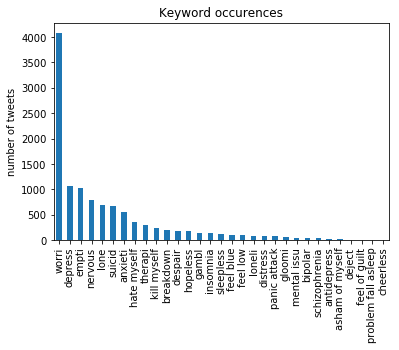

In [100]:
plot_occurences(final_df[has_keyword].keywords)

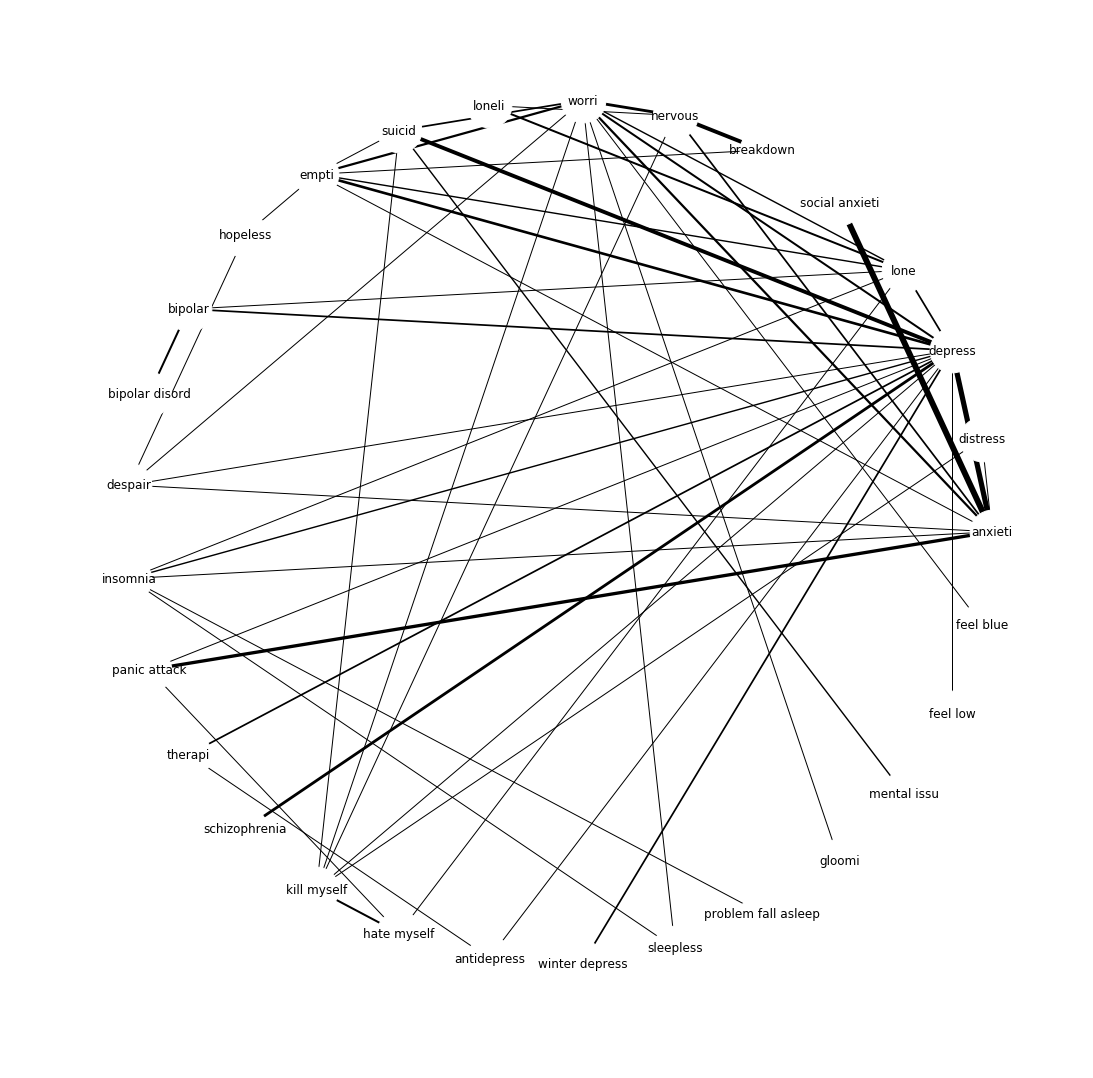

In [102]:
cooccurences = get_coocurrences(final_df[has_keyword])
draw_coocurences(cooccurences)

### Sentiment score

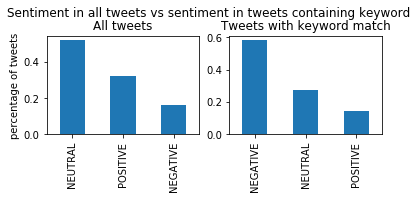

In [103]:
plt.suptitle('Sentiment in all tweets vs sentiment in tweets containing keyword')
plt.subplot(2,2,1)
plt.ylabel('percentage of tweets')
plt.title('All tweets')
(final_df.sentiment.value_counts()/final_df.sentiment.count()).plot(kind='bar')
plt.subplot(2,2,2)
plt.title('Tweets with keyword match')
(final_df[has_keyword].sentiment.value_counts()/final_df[has_keyword].sentiment.count()).plot(kind='bar')
plt.show()

### Gender

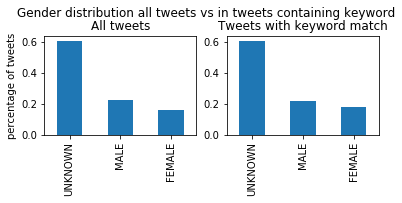

In [104]:
plt.suptitle('Gender distribution all tweets vs in tweets containing keyword')
plt.subplot(2,2,1)
plt.ylabel('percentage of tweets')
plt.title('All tweets')
(final_df.author_gender.value_counts()/final_df.author_gender.count()).plot(kind='bar')
plt.subplot(2,2,2)
plt.title('Tweets with keyword match')
(final_df[has_keyword].author_gender.value_counts()/final_df[has_keyword].author_gender.count()).plot(kind='bar')
plt.show()

### User analysis

We look at how many users are responsible for more than one post:

In [105]:
user_posts = final_df[has_keyword].author_user_id.value_counts()
user_posts.head()

3.126240e+09    192
2.555043e+09    168
2.707505e+08    127
2.577283e+09     74
3.301560e+09     67
Name: author_user_id, dtype: int64

We immediatley see that 3 users are posting very many tweets that contain a keyword, with the number quickly decreasing:

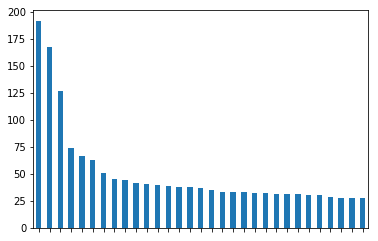

In [106]:
#looking at users with more than 25 posts for visibility
ax = user_posts[user_posts > 25].plot(kind='bar')
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

We look at posting time for a given user:

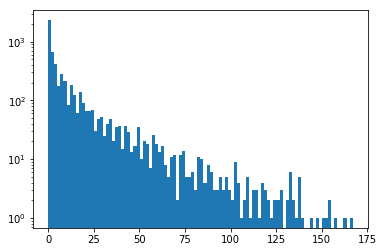

In [107]:
plt.hist(final_df[has_keyword].sort_values(by='published',ascending=True).groupby('author_user_id')\
['published'].diff().dropna().sort_values(ascending=False).map(lambda x: x.days), bins=100, log=True)
plt.show()

We look at the posts of a user who's tweets match very many keywords:

In [108]:
final_df[has_keyword][final_df.author_user_id == 3126239893].sort_values(by='published')['main'].sample(10)

/Users/lguillain/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


2866804                 @ezshokugeki they decided to put pink blood in despair arc and red blood in future arc
3138987                                                     @acethefrost @joshtruction is this despair i feel 
1213675                     @snowkitten_ she was talking about suicide 50 days ago. let's just pray it was not
389360                                                                                 the face of depression 
1608800    @nydylla the account got kinda hated for that one lmao. but it doesn't matter don't worry (don't...
2092863                                                                           @jubileus_ anxiety level max
3502587                @birussou @nydylla i hate this. but they take my memes in it so basically i hate myself
3746104    @_xenox hope against despair? i've never really noticed any meaningful intention in madoka if no...
325665                                                                               @himecatherine depression
7

### Temporal analysis

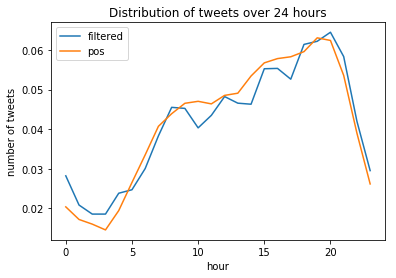

In [110]:
plot_daily(final_df[has_keyword])
plot_daily(final_df[final_df.sentiment == 'POSITIVE'])
plt.xlabel('hour')
plt.ylabel('number of tweets')
plt.legend(['filtered', 'pos', 'neg', 'neut'])
plt.title('Distribution of tweets over 24 hours')
plt.show()

/Users/lguillain/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


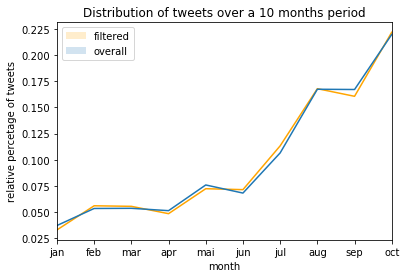

In [111]:
yearly_distribution = final_df[has_keyword].published.map(lambda x: x.month).value_counts() / final_df[has_keyword].published.count()
yearly_distribution2 = final_df.published.map(lambda x: x.month).value_counts() /  final_df.published.count()

sns.tsplot(data=yearly_distribution, time=yearly_distribution.index, color='orange')
sns.tsplot(data=yearly_distribution2, time=yearly_distribution2.index)
plt.legend(['filtered', 'overall'])
plt.ylabel('relative percetage of tweets')
plt.title('Distribution of tweets over a 10 months period')
plt.xticks(range(1, 11),['jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'oct'])
plt.xlabel('month')
plt.show()

### Location analysis

In [112]:
locations = process_location_data(final_df[has_keyword])
location_geo = gpd.GeoSeries(locations.apply(lambda z: Point(z[1], z[0]), 1), crs={'init': 'epsg:4326'})
location = gpd.GeoDataFrame(final_df[has_keyword][~final_df[has_keyword].geo_point.isnull()], geometry=location_geo) #merged data –useful later on–

In [113]:
municipalities = gpd.read_file('data/geodata/ch-municipalities.shp') #load data
municipalities.geometry = municipalities.geometry.to_crs(location_geo.crs) #change format

In [114]:
#join between region and location
counts = gpd.tools.sjoin(location, municipalities).groupby('id').size()

In [115]:
#add counts to the regions
municipalities.set_index('id', inplace=True)
municipalities['counts'] = counts
municipalities.fillna(0, inplace=True) #if we can't find match we have 0 tweets
municipalities.reset_index(inplace=True)

In [116]:
municipalities_0 = municipalities[municipalities.counts < 1]
municipalities_1 = municipalities[municipalities.counts >= 1]

In [117]:
SWISS_COORD = [46.85, 8.23]
swiss_map = folium.Map(location = SWISS_COORD, zoom_start = 8, tiles = 'cartodbpositron')

#layer with municipalities containing more than 10 tweets
swiss_map.choropleth(municipalities_1.to_json(), data = municipalities_1,
                     key_on = 'feature.properties.{}'.format('id'),
                    columns = ['id', 'counts'], fill_color = 'PuRd',
                     legend_name='Number of tweets', fill_opacity=0.9)
#layer with municipalities containing less than 10 tweets in total
swiss_map.choropleth(municipalities_0.to_json(), data = municipalities_0, 
                     key_on = 'feature.properties.{}'.format('id'),
                     columns = ['id', 'counts'], fill_color = 'PuBu', 
                     threshold_scale=[0, 1], legend_name='Area of little to no data',
                     fill_opacity=0.1, line_opacity=0.3)

In [118]:
swiss_map.save('dist.html')

In [119]:
%%HTML
<iframe width='900' height="500" src="dist.html"></iframe>

## 5. Processing Pipeline on the Second Dataset

#### Mapping from Dataset 1 to Dataset 2

Formatting is as follows: **Column in Dataset 2** -> Column in Dataset 1

- **author_user_id**           -> userId
- **geo_point**                -> longitude + latitude (or: placeLongitude + placeLatitude)
- **main**                     -> text
- **published**                -> createdAt
- **source_followers**         -> followersCount
- **source_following**         -> friendsCount (or is it folowwers that are following ?)
- **source_location**          -> userLocation


#### Dataset 1 having no equivalent : 
- id                                -> tweet ID
- truncated                         -> no idea, only NaNs
- placeId                           -> ID of where they are
- inReplyTo                         -> If it is a tweet reply
- source & sourceName, sourceUrl    -> what user used to send tweet (Android, website, and so on)
- userName                          -> username
- screenName                        -> name shown on tweets from username
- statusesCount                     -> number of status of user

#### Dataset 2 having no equivalent : 
- **author_gender**                 -> author's gender
- **lang**                          -> language of tweet (given)
- **sentiment**                     -> tweet's sentiment analysis (given)
- **source_spam_probability**       -> spam probability of tweet (given)
- **tags**                          -> hashtags contained in the tweet (in Dataset 1 stays in text)
- **tokenized**                     -> tokenized text of tweet (done by us)
- **keywords**                      -> keywords fund in tweets (done by us)

The dataset comes with a *txt schema*, giving us an idea of the meaning of each column in the *tsv file* containing the tweets. We were also given a sample file to get an overview of the data, but we also optained the complete set of tweets (5GB) in a _.zip_ file.

The dataset contains the following useful columns:

- **userId** : id identifying the user.
- **createdAt** : time the tweet was posted.
- **text** : content of the tweet.
- **placeLatitude** : latitude of the tweet.
- **placeLongitude** : longitude of the tweet.
- **sourceName** : username.
- **sourceUrl** : URL of the tweet.
- **followersCount** : number of followers.
- **friendsCount** : number of mutual follows.
- **statusesCount** : number of statuses of user.

The sample dataset contains a lot of NaN values, and each column contains at least 1% or more NaN values.

The complete analysis and code can be found in the [Basic Exploration dataset 1 notebook](Basic%20Exploration%20Dataset%201.ipynb)

## 7. Analysis of the Second Dataset

Due to issue with the cluster, we decide to use the dataset in local and perform the necessary processing steps locally.

By removing unnecessary columns, tweets containing websites, retweets, and general gibberish (a set of characters mixed with numbers), we can reduce the size of the dataset from  5.6 GB down to 1.2 GB. The code for this process can be found in the *run_d1.py* script. We save this dataset in a .csv file for further processing.

As mentioned previously, this set is not annotated with the language of the tweet. We thus needed to use an external language classification library to label the tweets and only keep English tweets. For efficiency reasons, we use the *guess_language* function from sprit. Using this function, the labeling of all 14 million tweets took about 2 hours.

After this we save the tweets that were labeled as English to an other .csv file.
Let us do a quick analysis of this dataset:

In [120]:
twitter_df2 = pd.read_csv('data/twitter-swisscom/dataset2_english.csv')

/Users/lguillain/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,5,6,7,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We perform some simple data processing that is needed after retrieving the file from the .csv.

While working on the tweets we addictionaly found issues with malformed columns, making us drop 300'000 columns, which do not contain the correct information.

In [121]:
twitter_df2.rename(columns={'createdAt':'published'}, inplace=True)
#get tweets that have a date, we consider tweets without dates to be garbage
twitter_df2 = twitter_df2[~twitter_df2.published.isnull()]
#transfrom to string so we can check formatting
twitter_df2['published'] = twitter_df2['published'].astype(str)
#remove deformed columns
tw = twitter_df2[twitter_df2.published.map(lambda x: len(x) == 19)]

print('number of malformed columns : ', len(twitter_df2[twitter_df2.published.map(lambda x: len(x) != 19)]))
#transform to date-time
tw.published = pd.to_datetime(tw['published'])

number of malformed columns :  301593


/Users/lguillain/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [122]:
#tw.to_pickle for later retrieving in script
#tw.to_pickle('data/twitter-swisscom/dataset2_english_clean.pkl')

We now look at how many tweets we have remaining: 

In [123]:
tw.count()

Unnamed: 0        2213098
Unnamed: 0.1      2213098
userId            2213098
published         2213098
text              2213098
longitude          930672
latitude           930670
inReplyTo          486053
truncated               8
placeLatitude     1604645
placeLongitude    1604648
sourceUrl         1426448
userName          1598300
screenName        1605836
followersCount    1605837
friendsCount      1605838
statusesCount     1605837
userLocation      1281440
lang              2213098
dtype: int64

We only have 1 million tweets remaining, which is not much given the initial size of the dataset.

From the previous dataset,we know that keywords are quite sparse, with at most $2\%$ matching. So despite this dataset spanning a longer amount of time, we still find that only very little usable tweets remain.

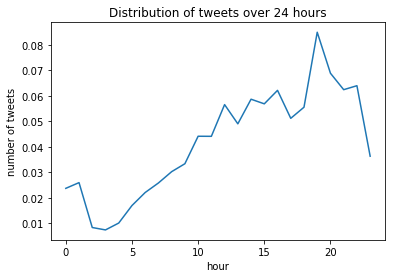

In [124]:
plot_daily(tw)
plt.xlabel('hour')
plt.ylabel('number of tweets')
plt.title('Distribution of tweets over 24 hours')

The temporal distribution over one day is similar to the distrubution we observed in part 2.

We note that we can find dates as early as 2002 in the dataset:

In [125]:
tw[tw.published.map(lambda x: int(x.year) <= 2006)].published

11928   2002-12-11 08:03:52
11939   2004-05-15 01:50:32
Name: published, dtype: datetime64[ns]

This must be an error, as twitter first went online in 2006. Due to the sparcity of tweets pre-2013 we only look at tweets after 2013.

In [126]:
tw = tw[tw.published.map(lambda x: int(x.year) >= 2013)]

We now look at the yearly distribution:

/Users/lguillain/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


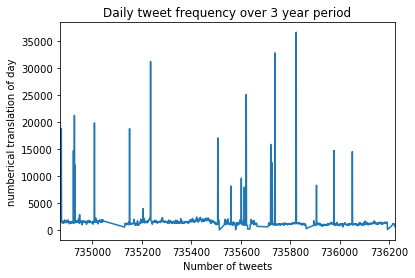

In [131]:
#convert values for plotting
yearly_distribution = tw.published.map(lambda x: x.date()).value_counts()
date = matplotlib.dates.date2num(yearly_distribution.index)
#plot
sns.tsplot(data=yearly_distribution, time=date)
plt.title('Daily tweet frequency over 3 year period')
plt.xlabel('Number of tweets')
plt.ylabel('numberical translation of day')
plt.show()

The plot we find is very odd. Again, we have no explanation for this.

Despite some of the issues with the dataset we run the keyword matching algorithm on it.

## 8. Conclusion